<a href="https://colab.research.google.com/github/quyongkeomut/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow---my-practice/blob/main/Chapter_16_part_1_Natural_Language_Processing_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [ ]:
!pip install keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: 

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_core
import keras_nlp
import os
from keras_nlp.metrics import Perplexity

Using TensorFlow backend


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## Tạo văn bản với văn phong giống Shakespeare

### Load tập dữ liệu (tất cả tác phẩm của Shakespeare)

In [ ]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("/content/drive/MyDrive/data_sets/shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

Sau khi load tập dữ liệu, ta cần mã hoá mỗi kí tự (hoặc mỗi từ) như một số nguyên

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

Ta thiết lập tokenizer mã hoá ở mức kí tự thay vì mức từ. Có một điều cần lưu ý là tokenizer mặc định chuyển văn bản sang chữ thường, nhưng ta có thể đặt lower=False nếu không muốn.

Ta có thể dùng tokenizer này để mã hoá một câu (hoặc danh sách các câu) và ngược lại. Nó cũng có thể cho biết có bao nhiêu kí tự phân biệt và tổng số kí tự trong văn bản:

In [ ]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3], [12, 5, 8, 3]])

['f i r s t', 'l a s t']

In [ ]:
max_id = len(tokenizer.word_index)
print(tokenizer.word_index)
print(max_id)

{' ': 1, 'e': 2, 't': 3, 'o': 4, 'a': 5, 'i': 6, 'h': 7, 's': 8, 'r': 9, 'n': 10, '\n': 11, 'l': 12, 'd': 13, 'u': 14, 'm': 15, 'y': 16, 'w': 17, ',': 18, 'c': 19, 'f': 20, 'g': 21, 'b': 22, 'p': 23, ':': 24, 'k': 25, 'v': 26, '.': 27, "'": 28, ';': 29, '?': 30, '!': 31, '-': 32, 'j': 33, 'q': 34, 'x': 35, 'z': 36, '3': 37, '&': 38, '$': 39}
39


In [ ]:
dataset_size = tokenizer.document_count
print(dataset_size)

1115394


In [ ]:
encoded = np.array(tokenizer.texts_to_sequences([shakespeare_text]))[0] - 1

### Chia tập dữ liệu có tính Thời gian

In [ ]:
train_size = dataset_size * 90//100
valid_size = dataset_size * 6//100

In [ ]:
print(train_size)
print(encoded.shape)
train_dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
valid_dataset = tf.data.Dataset.from_tensor_slices(encoded[train_size:train_size+valid_size])
test_dataset = tf.data.Dataset.from_tensor_slices(encoded[train_size+valid_size:])

1003854
(1115394,)


### Cắt tập dữ liệu thành nhiều cửa sổ

Mỗi cửa sổ có thể được xem như một mẫu dữ liệu, tức là mỗi mẫu sẽ là một chuỗi con tương đối ngắn của toàn bộ văn bản, và RNN sẽ được trải theo (huấn luyện trên) chuỗi con ngắn này.


In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 char ahead
train_dataset = train_dataset.window(window_length, shift=1, drop_remainder=True)
valid_dataset = valid_dataset.window(window_length, shift=1, drop_remainder=True)
test_dataset = test_dataset.window(window_length, shift=1, drop_remainder=True)

Để đảm báo tất cả ô cửa sổ chứa 101 kí tự, đặt *drop_remainder=True*

>Ta có thể điều chỉnh *n_steps*, nhưng vì RNN không thể học bất kì khuôn mẫu nào dài hơn *n_steps* nên đừng cắt chuỗi quá ngắn.

In [ ]:
train_dataset = train_dataset.flat_map(lambda window: window.batch(window_length))
valid_dataset = valid_dataset.flat_map(lambda window: window.batch(window_length))
test_dataset = test_dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
train_dataset = train_dataset.map(lambda window: (window[:-1], window[1:]))
train_dataset = train_dataset.shuffle(10000).batch(32)

valid_dataset = valid_dataset.map(lambda window: (window[:-1], window[1:]))
valid_dataset = valid_dataset.shuffle(10000).batch(32)

test_dataset = test_dataset.map(lambda window: (window[:-1], window[1:]))
test_dataset = test_dataset.shuffle(10000).batch(32)

In [ ]:
train_dataset = train_dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
valid_dataset = valid_dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
test_dataset = test_dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [ ]:
for x, y in train_dataset.take(1):
    print(x, y)

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]]

In [ ]:
train_dataset = train_dataset.prefetch(1)
valid_dataset = valid_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)

### Build và Train Model Char-RNN

In [ ]:
first_model = keras.models.Sequential([
    keras.layers.Dense(max_id),
    keras.layers.Dense(max_id),
    keras.layers.Dense(42),
    keras.layers.Dense(42),
    # for embedding

    keras.layers.GRU(128, return_sequences=True, input_shape=[None, 42],
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation='softmax'))
])

In [ ]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9,
                                        nesterov=True)
first_model.compile(loss=[keras.losses.SparseCategoricalCrossentropy()],
                    metrics=['accuracy', Perplexity()],
                    optimizer="adam")

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/models/cp_generate_shakespeare_model2.ckpt", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = first_model.fit(train_dataset, epochs=10,
                          validation_data=valid_dataset,)
                          #callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
   2842/Unknown - 732s 254ms/step - loss: 1.4771 - accuracy: 0.5500 - perplexity: 4.3803

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [ ]:
first_model.evaluate(test_dataset)

### Sử dụng mô hình Char-RNN

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/models/cp_generate_shakespeare_model.ckpt'
first_model = keras.saving.load_model(checkpoint_path)

In [ ]:
first_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, None, 39)          1560      
                                                                 
 dense_21 (Dense)            (None, None, 39)          1560      
                                                                 
 dense_22 (Dense)            (None, None, 42)          1680      
                                                                 
 dense_23 (Dense)            (None, None, 42)          1806      
                                                                 
 gru_8 (GRU)                 (None, None, 128)         66048     
                                                                 
 gru_9 (GRU)                 (None, None, 128)         99072     
                                                                 
 time_distributed_4 (TimeDi  (None, None, 39)         

#### Dự đoán kí tự tiếp theo

In [ ]:
def preprocess(texts):
    X = tf.ragged.constant(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
preprocess(['ac', 'bd']).dtype

tf.float32

In [ ]:
X_new = preprocess(['How are yo', 'I am very wel', 'nic'])
Y_pred = first_model.predict(X_new)
for y_pred in Y_pred:
    char = tokenizer.sequences_to_texts([[tf.argmax(y_pred[-1]).numpy()+1]])[0]
    print(char)

1/1 [==============================] - 0s 18ms/step
u
l
e


#### Sinh văn bản mới

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    Y_pred = first_model(X_new)
    char = None
    for y_pred in Y_pred:
        rescaled_probs = tf.math.log(y_pred[-1:]) / temperature
        char_id = tf.random.categorical(rescaled_probs, num_samples=1)[0]+1
        char = tokenizer.sequences_to_texts([char_id.numpy()])[0]
    return char
def complete_text(text, n_chars=50, temperature=1):
    new_text = text
    for _ in range(n_chars):
        new_text += next_char(new_text, temperature)
    return new_text

In [ ]:
print(complete_text('chance', temperature=1.1))

chance 'tis ventons;
therefore this first biondello, if 


### RNN trạng thái

In [ ]:
batch_size = 32
n_steps = 100
window_length = n_steps + 1

train_parts = np.array_split(encoded[:train_size], batch_size)
valid_parts = np.array_split(encoded[train_size:train_size+valid_size], batch_size)
test_parts = np.array_split(encoded[train_size+valid_size:], batch_size)

In [ ]:
train_parts

[array([19,  5,  8, ..., 19,  4, 11]),
 array([ 7,  1, 31, ..., 10,  7,  5]),
 array([18,  5,  9, ...,  0, 19,  3]),
 array([ 8,  0, 16, ..., 12,  1,  0]),
 array([ 6,  5, 14, ...,  0, 22, 11]),
 array([13, 18, 24, ...,  0,  6,  1]),
 array([ 8,  0, 18, ...,  5, 20,  6]),
 array([ 2, 17,  0, ..., 19,  1, 16]),
 array([17, 10, 27, ...,  0, 25,  5]),
 array([18,  2,  3, ...,  3,  2, 28]),
 array([10,  3, 13, ...,  2,  1,  0]),
 array([ 3, 19,  0, ..., 12,  5, 25]),
 array([ 3,  8, 18, ...,  0,  2,  3]),
 array([ 0, 21,  1, ...,  9,  1,  7]),
 array([ 7, 17,  0, ...,  4,  0, 14]),
 array([ 3,  9,  2, ...,  1, 11, 11]),
 array([28, 10,  2, ..., 24,  0,  2]),
 array([ 6,  1,  0, ...,  3,  8, 20]),
 array([ 1, 12,  0, ...,  0, 21, 13]),
 array([ 2, 17,  0, ...,  0, 19,  4]),
 array([ 2,  6,  1, ..., 13, 14, 21]),
 array([11,  1,  0, ...,  0,  9,  3]),
 array([ 0, 12,  3, ...,  0, 22, 11]),
 array([ 4,  9,  1, ..., 11, 11,  0]),
 array([24,  9,  1, ...,  3, 13,  8]),
 array([ 0, 20, 13, ..., 

In [ ]:
datasets = []
for part in train_parts:
    dataset = tf.data.Dataset.from_tensor_slices(part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
train_dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
train_dataset = train_dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
train_dataset = train_dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, max_id), Y_batch)
)
train_dataset = train_dataset.prefetch(1)

In [ ]:
datasets = []
for part in valid_parts:
    dataset = tf.data.Dataset.from_tensor_slices(part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
valid_dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
valid_dataset = valid_dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
valid_dataset = valid_dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, max_id), Y_batch)
)
valid_dataset = valid_dataset.prefetch(1)

In [ ]:
state_RNN_model = keras.models.Sequential([
    keras.layers.Dense(max_id, batch_input_shape=[batch_size, 100, 39]),
    keras.layers.Dense(max_id),
    keras.layers.Dense(42),
    keras.layers.Dense(42),
    # for embedding

    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation='softmax'))
])

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/models/cp_generate_shakespeare_state_RNN_model.ckpt", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
state_RNN_model.compile(loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'], optimizer='adam')
history = state_RNN_model.fit(train_dataset, epochs=70,
                              validation_data=valid_dataset,
                              callbacks=[ResetStatesCallback(), checkpoint_cb, early_stopping_cb])

Epoch 1/70
313/313 [==============================] - 98s 294ms/step - loss: 2.3643 - accuracy: 0.3214 - val_loss: 1.9752 - val_accuracy: 0.4029
Epoch 2/70
313/313 [==============================] - 80s 256ms/step - loss: 1.8781 - accuracy: 0.4400 - val_loss: 1.8173 - val_accuracy: 0.4489
Epoch 3/70
313/313 [==============================] - 79s 253ms/step - loss: 1.7361 - accuracy: 0.4781 - val_loss: 1.7369 - val_accuracy: 0.4718
Epoch 4/70
313/313 [==============================] - 81s 259ms/step - loss: 1.6583 - accuracy: 0.4986 - val_loss: 1.6867 - val_accuracy: 0.4858
Epoch 5/70
313/313 [==============================] - 82s 262ms/step - loss: 1.6099 - accuracy: 0.5110 - val_loss: 1.6473 - val_accuracy: 0.4980
Epoch 6/70
313/313 [==============================] - 82s 260ms/step - loss: 1.5757 - accuracy: 0.5205 - val_loss: 1.6175 - val_accuracy: 0.5046
Epoch 7/70
313/313 [==============================] - 84s 270ms/step - loss: 1.5497 - accuracy: 0.5268 - val_loss: 1.5955 - val_ac

(0.0, 2.0)

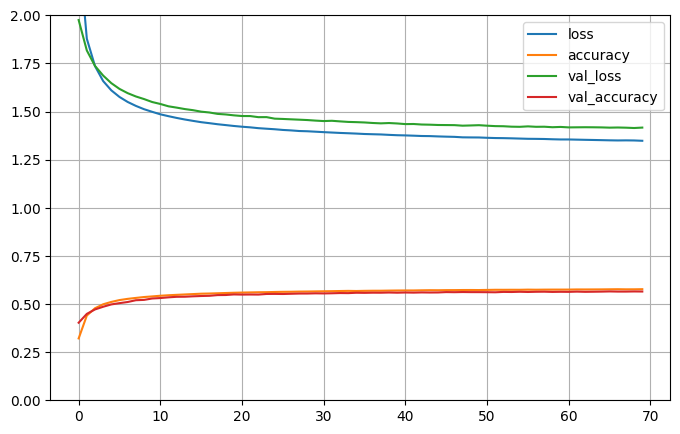

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-1] plt.show()

## Phân tích cảm xúc

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 1s 0us/step


In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0]])

1641221/1641221 [==============================] - 1s 0us/step


"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

### Tiền xử lý dữ liệu văn bản bằng toán tử Tensorflow

In [ ]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
train_size

NameError: ignored

In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
from collections import Counter
vocab = Counter()

In [ ]:
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocab.update(list(review.numpy()))

In [ ]:
print(len(vocab))
vocab.most_common()[:10]

53893


[(b'<pad>', 214309),
 (b'the', 61137),
 (b'a', 38564),
 (b'of', 33983),
 (b'and', 33431),
 (b'to', 27707),
 (b'I', 27019),
 (b'is', 25719),
 (b'in', 18966),
 (b'this', 18490)]

In [ ]:
vocab_size = 10000
truncated_vocab = [word for word, count in vocab.most_common()[:vocab_size]]

In [ ]:
words = tf.constant(truncated_vocab)
word_ids = tf.range(len(truncated_vocab), dtype=tf.int64)
vocab_initializeir = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_initializer, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie is faaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,     7, 10862]])>

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [ ]:
train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
# model:
embed_dim = 128
emo_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets,
                           embed_dim,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
emo_model.compile(loss="binary_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])
history = emo_model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 45s 44ms/step - loss: 0.6657 - accuracy: 0.5689
Epoch 2/5
782/782 [==============================] - 8s 10ms/step - loss: 0.4356 - accuracy: 0.8006
Epoch 3/5
782/782 [==============================] - 8s 11ms/step - loss: 0.2719 - accuracy: 0.8934
Epoch 4/5
782/782 [==============================] - 8s 11ms/step - loss: 0.1575 - accuracy: 0.9462
Epoch 5/5
782/782 [==============================] - 7s 9ms/step - loss: 0.1185 - accuracy: 0.9587


### Sử dụng các Embedding Tiền huấn luyện

In [ ]:
import tensorflow_hub as hub

In [ ]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50],
                   trainable=True), #sentence embedding
    keras.layers.Dense(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTXTJ6L/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTXTJ6L/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTXTJ6L/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 133s 162ms/step - loss: 0.3616 - accuracy: 0.8419
Epoch 2/5
782/782 [==============================] - 15s 19ms/step - loss: 0.1496 - accuracy: 0.9443
Epoch 3/5
782/782 [==============================] - 14s 18ms/step - loss: 0.0612 - accuracy: 0.9801
Epoch 4/5
782/782 [==============================] - 14s 18ms/step - loss: 0.0363 - accuracy: 0.9880
Epoch 5/5
782/782 [==============================] - 14s 18ms/step - loss: 0.0349 - accuracy: 0.9872


## Mạng Mã hoá - Giải mã cho Dịch máy Neuron (Neural Translation)

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
vocab_size = 100
embed_size = 10

In [ ]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.Bidirectional(keras.layers.GRU(512, return_state=True))
encoder_outputs, state_c_forward, state_c_backward = encoder(encoder_embeddings)
encoder_state = [keras.layers.Concatenate()([state_c_forward, state_c_backward])]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.GRUCell(1024)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
X = np.random.randint(100, size=1000*10*1).reshape(1000, 10, 1)
Y = np.random.randint(100, size=1000*15*1).reshape(1000, 15, 1)
X_decoder = np.concatenate((np.zeros((1000, 1, 1), dtype=np.int32), Y[:, :-1, :]), axis=1)
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 17s 62ms/step - loss: 4.6055
Epoch 2/2
32/32 [==============================] - 2s 57ms/step - loss: 4.6036


### RNN hai chiều

Một ô nhớ hồi tiếp thông thường chỉ xét đầu vào từ quá khứ đến hiện tại. Nói cách khác, đây là mô hình nhân quả, nghĩa là không thể nhìn thấy được tương lại. Loại RNN này chỉ có ý nghĩa khi làm việc với chuỗi thời gian, nhưng đối với các tác vụ NLP, có thể ta sẽ phải muốn biết các giá trị phía sau chuỗi trước khi mã hoá từ hiện tại.

Để thực hiện điều này, ta chạy hai tầng hồi tiếp trên cùng đầu vào: một tầng đọc chuỗi từ trái sang phải, tầng còn lại đọc từ phải sang trái. Sau đó ta gộp các đầu vào của chúng tại mỗi bước thời gian (thường là ghép nối chúng). Đây được gọi là *tầng hồi tiếp hai chiều*

![picture](https://drive.google.com/uc?export=view&id=1gN9vPN41ULLQbzC1YFUZXiYUD77imu0O)


In [ ]:
keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))

>Tầng Bidirectional sẽ tạo một bản sao của tầng GRU (nhưng ngược chiều), sau đó chạy cả hai tầng và ghép nối đầu ra của chúng

## Cơ chế tập trung